! Summary

    This is a busy notebook with multiple sections. For ease of understanding please read this description to understand how the notebook is structured.
    
    Section 1 : This section has code which does EDA and finally filters out users who have less than 50 reviews
    Section 2 : Recommendations using Popularity based Recommender Model
    Section 3 : Predictions & Recommendations Model based Collaborative Filtering (CF) using SVD algorithm from Surprise library
    Section 4 : Recommendations Memory using Item Item Collaborative Filtering (CF) using KNN model
    Section 5 : Predictions & Recommendations using Model based User User Collaborative Filtering (CF) using Scipy SVD algorithm
    Section 6 : Summary of results
    
    
    I have used two terimonology in my implementation here; these are Predictions and Recommendations. I see a Recommender System has two functions, one is to PREDICT the rating which a user may give to an item and second is to 'RECOMMEND' some top-N items to user ; hence i have explicitly called out which implementation does what.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Section 1 -> EDA

## 1.1 -> Read CSV File
### Since there is no headers specified in the csv file, we will provide column names while reading the file

In [2]:
data_with_timestamp = pd.read_csv('ratings_Electronics.csv', names=["user_id", "product_id", "rating", "timestamp"])
data_with_timestamp.head()

,user_id,product_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


## 1.2-> Remove Timestamp column

In [3]:
data_eda = data_with_timestamp.drop('timestamp',axis=1)

## 1.3-> Data Analysis of Ratings

### 1.3.1 -> Check for any missing values
    - We find that there are no missing values

In [4]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        
        return mz_table

table_data = missing_zero_values_table(data_eda)

Your selected dataframe has 3 columns and 7824482 Rows.
There are 0 columns that have missing values.


In [5]:
data_eda.isnull().sum()

user_id       0
product_id    0
rating        0
dtype: int64

### 1.3.2 -> Check how the ratings are distributed

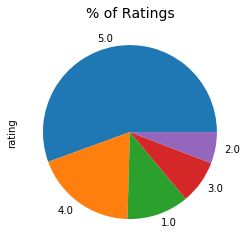

In [6]:
## We plot a pie graph to show how the ratings are split. We see that more than half of the ratings are 5
plt.title("% of Ratings", fontsize=14)
data_eda["rating"].value_counts().plot.pie()
plt.show()

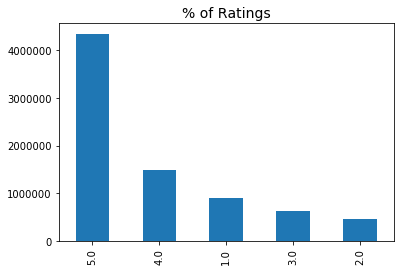

In [7]:
## Similar data represented in histogram
plt.title("% of Ratings", fontsize=14)
data_eda.rating.value_counts().plot(kind='bar')
plt.show()

### 1.3.3 -> Check how the count of ratings are distributed

    -We find that more products have lesser reviews, i.e. less number of reviews

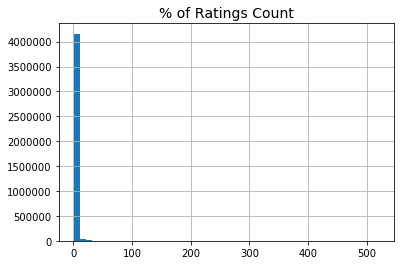

In [8]:
## Find number of ratings assigned to a product and see their distributions

ratings = pd.DataFrame(data_eda.groupby('user_id')['rating'].mean())
ratings['number_of_ratings'] = pd.DataFrame(data_eda.groupby('user_id')['rating'].count())

plt.title("% of Ratings Count", fontsize=14)
ratings["number_of_ratings"].hist(bins=50)
plt.show()

### 1.3.4 -> Check relationship b/w product rating and the count of ratings

    -We find that more product which have higher ratings are rated more often products which have lower ratings

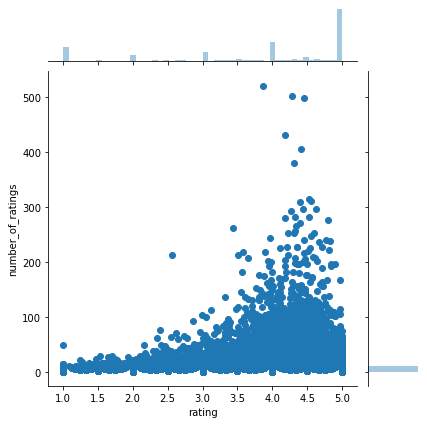

In [9]:
sns.jointplot(x='rating', y='number_of_ratings', data=ratings)
plt.show()

In [10]:
print ('Number of unique users is %d'%(len(data_eda['user_id'].unique())))
print ('Number of unique products is %d'%(len(data_eda['product_id'].unique())))

Number of unique users is 4201696
Number of unique products is 476002


## 1.4-> Filter users who have <50 reviews

In [11]:
data_grouped = data_eda.groupby('user_id')
data_filtered = data_grouped.filter(lambda x: x['user_id'].count()>50)
data_filtered.to_csv('filtered_electronic_ratings.csv')

# Section 2-> Recommendations Via Popularity based Model

# Objective:
    - Popularity model. This model is not actually personalized - it simply recommends to a user the most popular items that the user has not previously consumed
    
    Approach:
    - Read the filtered set of data
    - Calculate mean rating for each product
    - Calculate count of ratings for each product
    - Create a final dataframe which sorts products on 'mean ratings' and 'count of ratings'
    - Create a model class to mimic popularity based recommender system
    
    In some scenarios (not relevant to this usecase) Time plays an important role in ranking model. For e.g. on the news websites, freshness of time or the time it came has an important role. So the model we choose for ranking needs to take that into consideration. Some good examples of sites like reddit and hackerrank implement ranking considering time factor are below
    
    https://medium.com/hacking-and-gonzo/how-hacker-news-ranking-algorithm-works-1d9b0cf2c08d
    https://www.evanmiller.org/how-not-to-sort-by-average-rating.html
    https://medium.com/hacking-and-gonzo/how-reddit-ranking-algorithms-work-ef111e33d0d9

## 2.1 -> Read the filtered CSV File

In [12]:
#read filtered data file
data_popmdl = pd.read_csv('filtered_electronic_ratings.csv')

#print shapre of read data
print (data_popmdl.shape)

#drop first column
data_popmdl = data_popmdl.drop(data_popmdl.columns[0],axis=1)

#print shape again to verify that column has been dropped
print (data_popmdl.shape)

#print first 5 rows of data
data_popmdl.head()

(122171, 4)
(122171, 3)


,user_id,product_id,rating
0,AT09WGFUM934H,0594481813,3.0
1,A32HSNCNPRUMTR,0970407998,1.0
2,A17HMM1M7T9PJ1,0970407998,4.0
3,A3CLWR1UUZT6TG,0972683275,5.0
4,A3TAS1AG6FMBQW,0972683275,5.0


product_id  score  rank
38146  B0088CJT4U    204   1.0
24262  B003ES5ZUU    177   2.0
10820  B000N99BBC    163   3.0
37407  B007WTAJTO    156   4.0
37765  B00829TIEK    146   5.0

In [13]:
def prepare_dataframe_using_diff_statistical_measures(tmp_df):
    
    #rename column name
    tmp_df['score'] = tmp_df['rating']
    tmp_df = tmp_df.drop('rating',axis=1)

    #sort by score for each product
    tmp_df = tmp_df.sort_values(['score'], ascending=False)

    #Generate a recommendation rank based upon score 
    tmp_df['rank'] = tmp_df['score'].rank(ascending=False, method='first') 
    tmp_df = tmp_df.sort_values(['rank'], ascending=True)

    #print top n values
    print (tmp_df[['product_id','rank']][0:3])
    
    return tmp_df

# find COUNT of ratings for each product & use that as a basis to identify top recommendations
print ('\nDisplaying 5 recommendations based on COUNT of ratings')
tmp_df_count_based = data_popmdl.groupby('product_id')['rating'].count().reset_index()
final_data_count_based = prepare_dataframe_using_diff_statistical_measures(tmp_df_count_based)

# find MEAN of ratings for each product & use that as a basis to identify top recommendations
print ('\nDisplaying 5 recommendations based on MEAN of ratings')
tmp_df_average_based = data_popmdl.groupby('product_id')['rating'].mean().reset_index()
final_data_mean_based = prepare_dataframe_using_diff_statistical_measures(tmp_df_average_based)

# Another approach which is very interesting is 'Wilson Confidence Interval'. Good reads on the approach are available at:
# https://medium.com/hacking-and-gonzo/how-reddit-ranking-algorithms-work-ef111e33d0d9
# https://www.evanmiller.org/how-not-to-sort-by-average-rating.html


Displaying 5 recommendations based on COUNT of ratings
       product_id  rank
38146  B0088CJT4U   1.0
24262  B003ES5ZUU   2.0
10820  B000N99BBC   3.0

Displaying 5 recommendations based on MEAN of ratings
       product_id  rank
47154  B00LKG1MC8   1.0
18649  B001UE6HZ2   2.0
18704  B001UKJ8FC   3.0


## 2.2 -> Create class for making recommendations

In [14]:
class PopularityBasedRecommender:
    
    def __init__(self, input_df):
        self.df = input_df
    
    def recommend_products(self, user_id, howmany=5):
        recommendations_df = self.df.head(howmany)['product_id']
        return recommendations_df

## 2.3 -> Make recommendations

    We will use the dataframe which is based on the mean ratings of the movie as ranking measure.
    We will print recommendations for two different users.
    Since these are non-personalized recommendations we will get the same movies which are recommended to both users

In [15]:
#instantiate popularity based model
popularity_model = PopularityBasedRecommender(final_data_mean_based)

#make predictions for a user at 0th id
print("\nHere is the recommendation for the userId: %s\n" %(data_popmdl['user_id'][0]))
print (popularity_model.recommend_products(data_popmdl['user_id'][0], 5))

#make predictions for a user at 10th id
print("\nHere is the recommendation for the userId: %s\n" %(data_popmdl['user_id'][10]))
print (popularity_model.recommend_products(data_popmdl['user_id'][0], 5))


Here is the recommendation for the userId: AT09WGFUM934H

47154    B00LKG1MC8
18649    B001UE6HZ2
18704    B001UKJ8FC
18703    B001UK6UO4
37782    B0082N9DGY
Name: product_id, dtype: object

Here is the recommendation for the userId: A1E3OB6QMBKRYZ

47154    B00LKG1MC8
18649    B001UE6HZ2
18704    B001UKJ8FC
18703    B001UK6UO4
37782    B0082N9DGY
Name: product_id, dtype: object


# Section 3 -> Predictions & Recommentations Using Model Based Collaborative Filtering (CF)

## SVD Implementation

    This section of notebook has a sample implementation for a model based collaborative filtering using SVD algorithm
    
#### Collaborative Filtering 
    is one of the approaches for developing a recommender system. We could split CF techniques under two broad categories which can have further sub-categories

- Memory based
    - User User filtering
    - Item Item filtering
- Model based
    - SVD
    - Matrix Factorization
    - Deep Learning based 

In Memory based CF we use similarity measures (cosine / pearson) to either identify similar users or similar items and then we do a weighted average of the similarity scores to recommended newer items to the user which he/she may like. G

In Model based CF we use ML model to predict rating which a user might give to newer items and basis the ratings we recommend the items. So in model based CF, we have some actual ratings which have been given to an item and then there are predicted ratings. So, we could apply metrics like RMSE to see how good/bad the model is performing.

![title](cf-types.png)

(Image courtesy: https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0)

## 3.1 -> Read filtered CSV File

In [16]:
#read filtered data file
data_modl_cf = pd.read_csv('filtered_electronic_ratings.csv')

#print shapre of read data
print (data_modl_cf.shape)

#drop first column
data_modl_cf = data_modl_cf.drop(data_modl_cf.columns[0],axis=1)

#print shape again to verify that column has been dropped
print (data_modl_cf.shape)

#print first 5 rows of data
data_modl_cf.head()

(122171, 4)
(122171, 3)


,user_id,product_id,rating
0,AT09WGFUM934H,0594481813,3.0
1,A32HSNCNPRUMTR,0970407998,1.0
2,A17HMM1M7T9PJ1,0970407998,4.0
3,A3CLWR1UUZT6TG,0972683275,5.0
4,A3TAS1AG6FMBQW,0972683275,5.0


## 3.2 -> Build User User Collaborative Filtering model Using SVD

    - Model-based Collaborative Filtering: Singular Value Decomposition
    
    - load the required surprise library classes
    - Run a grid search to identify the best hyper parameters for SVD algorithm

In [17]:
from surprise import Reader
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV

# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(1, 5.0))

# The columns must correspond to user id, item id and ratings (in that order).
data_srp_cf = Dataset.load_from_df(data_modl_cf[['user_id', 'product_id', 'rating']], reader)

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(data_srp_cf)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9833730913555401
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


## 3.2 - Method to make recommendations for given user

In [18]:
def predictions_and_recommendations(preds,user,num_recommendation):
    recommended_item = []
    recommended_item_rating = []
    
    # scan through the predictions set and extract items which can be recommended to this user.
    for pred in preds:
        
        if pred[0]==user:
            recommended_item.append(pred[1])
            recommended_item_rating.append(pred[3])
               
    # create a DF
    recommendations_df = pd.DataFrame(data=list(zip(recommended_item, recommended_item_rating)),columns=['Items','Ratings'])
    recommendations_df = recommendations_df.sort_values(by=['Ratings'], ascending=False)[0:num_recommendation]
    return recommendations_df

## 3.3 - Create final SVD model using the identified best parameters

In [19]:
final_algo = SVD(n_epochs=10, lr_all=0.005, reg_all= 0.4)

trainset = data_srp_cf.build_full_trainset()
final_algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions = final_algo.test(testset)

## 3.4 - Make recommendations

    - Here we do two things
    - 1. Predict the ratings which a user would make for a particular movie
    - 2. Recommend movies which the user may want to see basis their Predicted ratings

In [20]:
pred_recommendations = predictions_and_recommendations(predictions, 'A100WO06OQR8BQ',5)
print ( pred_recommendations)

            Items   Ratings
10389  B000M2TAN4  4.252485
31341  B0052SCU8U  4.250815
18647  B001UI2FPE  4.232908
28280  B004ELA0SS  4.232302
42545  B00BQ4F9ZA  4.225288


# Section 4 - Recommendations Using Memory based Collaborative Item Item Filtering using KNN

## 4.1 -> Read filtered CSV File

In [21]:
#read filtered data file
data_ii = pd.read_csv('filtered_electronic_ratings.csv')

#print shapre of read data
print (data_ii.shape)

#drop first column
data_ii = data_ii.drop(data_ii.columns[0],axis=1)

#print shape again to verify that column has been dropped
print (data_ii.shape)

#print first 5 rows of data
data_ii.head()

(122171, 4)
(122171, 3)


,user_id,product_id,rating
0,AT09WGFUM934H,0594481813,3.0
1,A32HSNCNPRUMTR,0970407998,1.0
2,A17HMM1M7T9PJ1,0970407998,4.0
3,A3CLWR1UUZT6TG,0972683275,5.0
4,A3TAS1AG6FMBQW,0972683275,5.0


## 4.2 -> Create a matrix with products as y-axis and users on x-axis. Fill missing ratings with 0

In [22]:
final_ratings_matrix_ii = data_ii.pivot(index = 'product_id', columns ='user_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix_ii.shape)
final_ratings_matrix_ii.head()

Shape of final_ratings_matrix:  (47155, 1466)


user_id,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
product_id,,,,,,,,,,,,,,,,,,,,,
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4.3 -> Train KNN Model to identify 10 neighbors

In [23]:
from sklearn.neighbors import NearestNeighbors

knn_model = NearestNeighbors(n_neighbors=10)
knn_model.fit(final_ratings_matrix_ii)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

## 4.4 -> Create class to make recommendations

In [24]:
class ItemItemRecommender:
    def __init__(self, knnModel, itemUserMatrix):
        self.model = knnModel
        self.matrix = itemUserMatrix
        self.df = self.matrix.reset_index()
        
    def recommend_products(self, tst_item):
        tst_data = self.matrix.loc[tst_item,:].to_numpy()
        distances, indices = knn_model.kneighbors(tst_data.reshape(1,-1), n_neighbors=5)
        distances = distances.flatten()
        indices = indices.flatten()

        for i in range(0, len(distances)):
            print ('Product %s is similar to %s'%(self.df.iloc[indices[i]]['product_id'],tst_item))
        
        print ('--------------------\n')
            
    def recommend_products_by_index(self, tst_idx):
        tst_data = self.matrix.iloc[tst_idx,:].to_numpy()
        distances, indices = knn_model.kneighbors(tst_data.reshape(1, -1), n_neighbors=5)
        distances = distances.flatten()
        indices = indices.flatten()

        for i in range(0, len(distances)):
            print ('Product %s is similar to %s'%(tmp_df.iloc[indices[i]]['product_id'],tst_item))
        print ('--------------------\n')

## 4.4 -> Make recommendations

In [25]:
iiRecommender = ItemItemRecommender(knn_model, final_ratings_matrix_ii)
iiRecommender.recommend_products('B00006BH7F')
#iiRecommender.recommend_products_by_index(tst_idx)

Product B000056SRE is similar to B00006BH7F
Product B00005OP2T is similar to B00006BH7F
Product B00004Z5L8 is similar to B00006BH7F
Product B00005NKXS is similar to B00006BH7F
Product B00005O0LH is similar to B00006BH7F
--------------------



# Section 5-> Model based Collaborative User User filtering with Scipy SVD Implementation

## 5.1 -> Read filtered CSV File

In [26]:
#read filtered data file
data_uu = pd.read_csv('filtered_electronic_ratings.csv')

#print shapre of read data
print (data_uu.shape)

#drop first column
data_uu = data_uu.drop(data_uu.columns[0],axis=1)

#print shape again to verify that column has been dropped
print (data_uu.shape)

#print first 5 rows of data
data_uu.head()

(122171, 4)
(122171, 3)


,user_id,product_id,rating
0,AT09WGFUM934H,0594481813,3.0
1,A32HSNCNPRUMTR,0970407998,1.0
2,A17HMM1M7T9PJ1,0970407998,4.0
3,A3CLWR1UUZT6TG,0972683275,5.0
4,A3TAS1AG6FMBQW,0972683275,5.0


## 5.2 -> Create a matrix with users on y-axis and products on x-axis. Fill missing ratings with 0

In [27]:
final_ratings_matrix_uu = data_uu.pivot(index = 'user_id', columns ='product_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix_uu.shape)
final_ratings_matrix_uu.head()

Shape of final_ratings_matrix:  (1466, 47155)


product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
df_CF = data_uu.copy()
df_CF.head()

#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df_uu = df_CF.pivot(index = 'user_id', columns ='product_id', values = 'rating').fillna(0)
pivot_df_uu.shape
pivot_df_uu.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5.3 -> Add a 'user index' column to the dataframe

In [29]:
pivot_df_uu['user_index'] = np.arange(0, pivot_df_uu.shape[0], 1)
pivot_df_uu.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


## 5.4 -> Create a mapping of actual user id's and user-index.
    - We would refer to this index while making predictions

In [30]:
user_index_mapping = pivot_df_uu['user_index']
user_index_mapping_df = user_index_mapping.to_frame()
user_index_mapping_df = user_index_mapping_df.reset_index()

## 5.5 -> Change index of dataframe to the 'user_index' column

In [31]:
pivot_df_uu.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df_uu.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5.6 -> SVD implementation using scipy

### 5.6.1 - Run SVD and make predictions

In [32]:
from scipy.sparse.linalg import svds

# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df_uu, k = 10)

# Construct diagonal array in SVD
sigma = np.diag(sigma)

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df_uu = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df_uu.columns)
preds_df_uu.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.003574,0.004106,0.004114,0.001519,0.003071,0.005844,0.000504,0.010546,0.002704,0.000367,...,0.000605,0.044718,0.002920,0.060948,-0.002402,0.006796,0.001514,0.131030,0.059635,0.015090
1,0.002569,0.005363,0.013273,0.006607,0.001513,0.013490,0.000304,-0.004528,0.001254,0.011161,...,0.000228,0.029384,0.000089,0.000636,-0.003266,-0.000550,0.004386,-0.039361,-0.006408,0.003812
2,-0.002541,0.002095,0.017831,0.006890,-0.002171,0.005816,0.003470,-0.004045,-0.001645,0.010979,...,-0.000323,0.009498,-0.002494,-0.016874,0.019722,-0.002480,-0.000172,-0.003130,-0.011089,-0.004675
3,0.003963,0.001919,0.007592,0.002871,0.002890,0.003592,0.000112,0.005946,0.002477,0.000063,...,0.000616,-0.003098,0.003469,-0.003241,-0.000767,0.000159,0.002695,-0.015041,-0.007067,0.003539
4,0.000112,0.002091,0.008902,0.004068,0.000342,0.006062,0.001018,-0.000888,0.000375,0.006435,...,0.000007,-0.000698,-0.000316,-0.024802,0.004501,-0.002146,0.001284,-0.048613,-0.016151,-0.003332


## 5.7 -> Define method to make Recommendations

In [33]:
# Recommend the items with the highest predicted ratings

def predictions_recommendations(user, user_index_mapping_df, pivot_df, preds_df, num_recommendations):
      
    #get the user index corresponding to passed user
    user_idx = user_index_mapping_df.loc[user_index_mapping_df['user_id']==user]['user_index'].to_list()[0]

    #sorted_user_ratings
    ##sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    
    #sorted_user_predictions
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

## 5.8 -> Make recommendations

    - Here we do two things
    - 1. Predict the ratings which a user would make for a particular movie
    - 2. Recommend movies which the user may want to see basis their Predicted ratings

In [34]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 'A10AFVU66A79Y1'
num_recommendations = 5
predictions_recommendations(userID, user_index_mapping_df, pivot_df_uu, preds_df_uu, num_recommendations)


Below are the recommended items for user(user_id = A10AFVU66A79Y1):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          0.912715
B000N99BBC                  0.0          0.753376
B00829TIEK                  0.0          0.726695
B004CLYEDC                  0.0          0.658597
B008DWCRQW                  0.0          0.657139


c:\machinelearning\anaconda3\envs\recommender-system\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


## 5.9 -> Evaluate recommendations

In [35]:
# Actual ratings given by the users
final_ratings_matrix_uu.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Average ACTUAL rating for each item
final_ratings_matrix_uu.mean()

product_id
0594481813    0.002046
0970407998    0.003411
0972683275    0.010232
1400501466    0.010232
1400501520    0.003411
                ...   
B00LED02VY    0.002729
B00LGN7Y3G    0.003411
B00LGQ6HL8    0.017053
B00LI4ZZO8    0.006139
B00LKG1MC8    0.003411
Length: 47155, dtype: float64

In [37]:
# Predicted ratings 
preds_df_uu

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.003574,0.004106,0.004114,0.001519,0.003071,0.005844,0.000504,0.010546,0.002704,0.000367,...,0.000605,0.044718,0.002920,0.060948,-0.002402,0.006796,0.001514,0.131030,0.059635,0.015090
1,0.002569,0.005363,0.013273,0.006607,0.001513,0.013490,0.000304,-0.004528,0.001254,0.011161,...,0.000228,0.029384,0.000089,0.000636,-0.003266,-0.000550,0.004386,-0.039361,-0.006408,0.003812
2,-0.002541,0.002095,0.017831,0.006890,-0.002171,0.005816,0.003470,-0.004045,-0.001645,0.010979,...,-0.000323,0.009498,-0.002494,-0.016874,0.019722,-0.002480,-0.000172,-0.003130,-0.011089,-0.004675
3,0.003963,0.001919,0.007592,0.002871,0.002890,0.003592,0.000112,0.005946,0.002477,0.000063,...,0.000616,-0.003098,0.003469,-0.003241,-0.000767,0.000159,0.002695,-0.015041,-0.007067,0.003539
4,0.000112,0.002091,0.008902,0.004068,0.000342,0.006062,0.001018,-0.000888,0.000375,0.006435,...,0.000007,-0.000698,-0.000316,-0.024802,0.004501,-0.002146,0.001284,-0.048613,-0.016151,-0.003332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,0.003577,0.001875,0.009949,0.002917,0.002647,0.003455,0.000387,0.004804,0.002282,0.000025,...,0.000415,-0.000262,0.002551,-0.003902,0.001370,0.000188,0.002877,-0.013252,-0.006870,0.003850
1462,0.002852,0.001359,0.007070,0.001840,0.002016,0.002135,0.000270,0.004077,0.001726,-0.000665,...,0.000319,0.002752,0.001885,0.003722,0.000606,0.000696,0.002220,0.001166,-0.001092,0.004338
1463,0.004656,0.011979,-0.025424,-0.009713,0.004219,0.005523,-0.007535,0.016636,0.003479,-0.002248,...,-0.000143,0.229093,0.002307,0.269808,-0.031256,0.031387,-0.000217,0.549700,0.291391,0.043973
1464,0.001332,0.002572,0.004892,0.002653,0.001204,0.004563,0.000493,0.008788,0.001024,0.003317,...,0.000235,0.008146,0.000673,-0.000828,-0.000227,0.000249,0.001539,-0.010723,0.001168,0.002046


In [38]:
# Average PREDICTED rating for each item
preds_df_uu.mean()

product_id
0594481813    0.002380
0970407998    0.002716
0972683275    0.010664
1400501466    0.004101
1400501520    0.001564
                ...   
B00LED02VY    0.000794
B00LGN7Y3G    0.002109
B00LGQ6HL8    0.014652
B00LI4ZZO8    0.004393
B00LKG1MC8    0.003965
Length: 47155, dtype: float64

In [39]:
rmse_df_uu = pd.concat([final_ratings_matrix_uu.mean(), preds_df_uu.mean()], axis=1)
rmse_df_uu.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df_uu.shape)
print (rmse_df_uu.head())

RMSE = round((((rmse_df_uu.Avg_actual_ratings - rmse_df_uu.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))

(47155, 2)
            Avg_actual_ratings  Avg_predicted_ratings
product_id                                           
0594481813            0.002046               0.002380
0970407998            0.003411               0.002716
0972683275            0.010232               0.010664
1400501466            0.010232               0.004101
1400501520            0.003411               0.001564

RMSE SVD Model = 0.00342 



# Section 6

    - We can draw following conclusions from these implementations
    
    1. Popularity based models are a good starting point when there is little data available about user's preferences or items's rating. While the model is not personalized to individual users but its better than not having any recommender system in place
    
    2. Model based CF systems are quite simple to implement but they do have major issues with sparsity. For e.g. to build predictions for Users & Items (not ranked earlier by user) it's a fairly memory intensive operation. As number of user's and products would scale this would definetively be an issue.
    
    3. Memory based Item Item CF systems were by far the simplest to implement. Since these model draw similarity between products they are fairly more scalable.
    
    4. Model based User User CF systems using Scipy SVD are more complex to implement. Definetely not a recommended option given how simple the implementation can be using a library like Surprise.
    
    
### Few Open Areas
    1. How to measure accuracy of Popularity based model ? Could not figure out a way for doing that.
    2. Are there any good reasons to use Scipy SVD implementation over Surprise?
    3. How Robust is my Item Item CF implementation ? Could i improve it further ?